In [1]:
import spacy
import os
import xml.etree.ElementTree as ET
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from spacy import displacy
import scipy.stats
from spacy.tokens import Doc

# Tokenize only on whitespace to compare spacy tagger with sparv's tags
class WhitespaceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(" ")
        return Doc(self.vocab, words=words)

nlp = spacy.load(os.path.join("..", "sv_model_upos", "sv_model0", "sv_model_upos0-0.0.0"))
#nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

In [1]:
# Look at distribution of sentence lengths across languages/times

def traverseSwed(filepath, process, relative=False):
    parser = ET.iterparse(file_path, events=('start','end'))
    parser = iter(parser)
    event, root = next(parser)

    words = ""
    pos = []
    sum_overlaps= 0 
    num_para = 0
    i = 0
    agLength, agDepth, agLeaves = [], [], []
    for event, elem in parser:
        if elem.tag == "w":
            if event == "end":
                #print(elem.attrib['pos'])
                words +=  elem.text + " "
                elem.clear()
            root.clear()
        if elem.tag == "sentence" and event=="end":
            words = words.strip()
            if len(words) == 0: continue
            doc = nlp(words)
            tok = list(doc.sents)[0].root
                
            agLength += [len(doc)]
            agDepth += [treeDepth(tok)/len(doc)]
            agLeaves += [numLeafs(tok)/len(doc)]
            
            words = ""
            i += 1
        if i == 10000: break
    return agLength, agDepth, agLeaves
            
def traverseFin(filepath, process, relative=False):
    agLength, agDepth, agLeaves = [], [], []
    num_sentences = 0
    with open(file_path) as reader:
        words = []
        pos = []
        for line in reader:
            # Start of sentence
            if line[:9] == "<sentence": 
                words = []
                pos_spacy=pos_sparv=pos=[]
            # End of sentence
            if line[:11] == "</sentence>": 
                if(len(words)) == 0: continue
                sent = " ".join(words)
                # print(words)
                doc = nlp(sent)
                tok = list(doc.sents)[0].root
                
                agLength += [len(doc)]
                agDepth += [treeDepth(tok)/len(doc)]
                agLeaves += [numLeafs(tok)/len(doc)]
                
                num_sentences += 1
            # Split up by sentence
            # If at a text line and not just tags
            if line[0] != "<": 
                wordInfo = line.split()
                #print(wordInfo)
                words += [wordInfo[0]]
                pos += [wordInfo[1]]
            if num_sentences == 10000: break
    
    return agLength, agDepth, agLeaves


"""
    For a sentence with the root token tok, returns the depth of the token's subtree. 
"""
def treeDepth(tok):
    if len(list(tok.children)) == 0: return 0 
    
    depths = np.array([treeDepth(c) for c in tok.children]).flatten()
    return max(depths) + 1

"""
    For a sentence with the root token tok, returns the number of leaves in the token's subtree. 
"""
def numLeafs(tok): 
    if len(list(tok.children)) == 0: return 1
    
    leafs = np.array([numLeafs(c) for c in tok.children]).flatten()
    return sum(leafs)

In [32]:
"""
    Given a list of counts for some metric (eg. sentence length), plot the metric
    for the two countries and print the result of a KS test to see see if the two distributions 
    are statistically significant in their difference. 
"""
def showResults(res1, res2, label1, label2, title):
    plt.hist(res1, alpha=0.5, label=label1, density=True)
    plt.hist(res2, alpha=0.5, label=label2, density=True)
    plt.legend()
    plt.title(title)
    plt.show()

    print(f"{label1} stats: {scipy.stats.describe(res1)}")
    print(f"{label2} stats: {scipy.stats.describe(res2)}")
    print("\nIndependence t-test: ", scipy.stats.ks_2samp(res1, res2))

### Finnish vs. Swedish Comparisons: 1870s
First is a comparison between Swedish and Finnish newspapers from the 1870s. 

In [22]:
filesSwe = ["kubhist2-carlscronaswekoblad-1870.xml", 
            "kubhist2-lundsweckoblad-1870.xml", 
            "kubhist2-norrkopingstidningar-1870.xml"]

lengthS, depthS, leafS = [],[],[]
for name in filesSwe: 
    file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2", name)
    l, d, f, = traverseSwed(file_path, numLeafs, True)
    lengthS += l
    depthS += d
    leafS += f

In [29]:
filesFin = ["klk-sv-1870.vrt",
           "klk-sv-1874.vrt", 
           "klk-sv-1878.vrt"]
lengthF, depthF, leafF = [],[],[]
for name in filesFin: 
    file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", name)
    l, d, f = traverseFin(file_path, numLeafs, True)
    lengthF += l
    depthF += d
    leafF += f

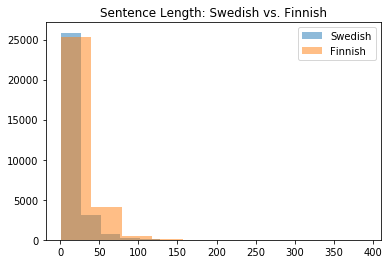

Swedish stats: DescribeResult(nobs=30000, minmax=(1, 254), mean=12.711833333333333, variance=271.67744922052964, skewness=3.320371566624919, kurtosis=18.825124645982026)
Finnish stats: DescribeResult(nobs=30000, minmax=(1, 390), mean=21.915233333333333, variance=435.3806272997989, skewness=2.495281084202087, kurtosis=14.727359923508303)

Independence t-test:  Ttest_indResult(statistic=-59.94892247338401, pvalue=0.0)


In [30]:
showResults(lengthS, lengthF, "Swedish", "Finnish", "Sentence Length: Swedish vs. Finnish")

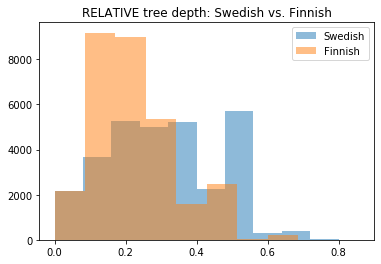

Swedish stats: DescribeResult(nobs=30000, minmax=(0.0, 0.8), mean=0.2964122598058318, variance=0.02382780020697767, skewness=0.08757792725749111, kurtosis=-0.5537783175443818)
Finnish stats: DescribeResult(nobs=30000, minmax=(0.0, 0.8571428571428571), mean=0.22986561594256769, variance=0.016158977098098635, skewness=0.8112612694502062, kurtosis=0.43153467032985926)

Independence t-test:  Ttest_indResult(statistic=57.64061196248585, pvalue=0.0)


In [31]:
showResults(depthS, depthF, "Swedish", "Finnish", "RELATIVE tree depth: Swedish vs. Finnish")

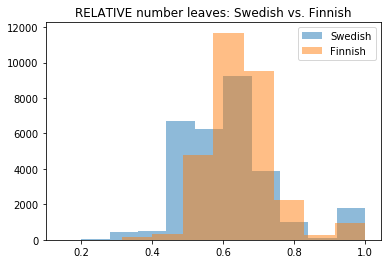

Swedish stats: DescribeResult(nobs=30000, minmax=(0.2, 1.0), mean=0.6282786558321322, variance=0.017879751356547166, skewness=0.9421176752313591, kurtosis=1.5871406309988068)
Finnish stats: DescribeResult(nobs=30000, minmax=(0.14285714285714285, 1.0), mean=0.6446672206705044, variance=0.010550591697062697, skewness=0.9740379539424052, kurtosis=3.2067547151422984)

Independence t-test:  Ttest_indResult(statistic=-16.834898448122363, pvalue=1.937625911965083e-63)


In [32]:
showResults(leafS, leafF, "Swedish", "Finnish", "RELATIVE number leaves: Swedish vs. Finnish")

In [23]:
# Save the 
import pickle
swed = {"lenghts": lengthS, 
       "leaves": leafS, 
       "depths": depthS}
fin = {"lenghts": lengthF, 
       "leaves": leafF, 
       "depths": depthF}
with open(os.path.join("data", "swed.pickle"), 'wb') as f:
    pickle.dump(swed, f)
"""with open(os.path.join("data", "fin.pickle"), 'wb') as f:
    pickle.dump(fin, f)"""

'with open(os.path.join("data", "fin.pickle"), \'wb\') as f:\n    pickle.dump(fin, f)'

In [36]:
with open(os.path.join("data", "fin.pickle"), 'rb') as f:
    fin = pickle.load(f)

In [4]:
# DO WITH OLDEST AS WELL TO COMPARE
filesSwe = ["kubhist2-carlscronaswekoblad-1780.xml", 
            "kubhist2-lundsweckoblad-1780.xml", 
            "kubhist2-norrkopingstidningar-1780.xml"]

lengthS, depthS, leafS = [],[],[]
for name in filesSwe: 
    file_path = os.path.join("/share/magpie/datasets/Swedish", "kubhist2", name)
    l, d, f, = traverseSwed(file_path, numLeafs, True)
    lengthS += l
    depthS += d
    leafS += f

In [5]:
filesFin = ["klk-sv-1782.vrt",
           "klk-sv-1784.vrt",
           "klk-sv-1789.vrt"]
lengthF, depthF, leafF = [],[],[]
for name in filesFin: 
    file_path = os.path.join("/share/magpie/datasets/Swedish", "klk-sv-1771-1879-vrt", name)
    l, d, f = traverseFin(file_path, numLeafs, True)
    lengthF += l
    depthF += d
    leafF += f

In [6]:
import pickle
swed = {"lenghts": lengthS, 
       "leaves": leafS, 
       "depths": depthS}
fin = {"lenghts": lengthF, 
       "leaves": leafF, 
       "depths": depthF}
with open(os.path.join("data", "swedOld.pickle"), 'wb') as f:
    pickle.dump(swed, f)
with open(os.path.join("data", "finOld.pickle"), 'wb') as f:
    pickle.dump(fin, f)

In [24]:
lengthFNew, depthFNew, leafFNew = [],[],[]
lengthSNew, depthSNew, leafSNew = [],[],[]
swed, fin = {}, {}
with open(os.path.join("data", "swed.pickle"), 'rb') as f:
    swed = pickle.load(f)
    lengthSNew, depthSNew, leafSNew = swed.values()
with open(os.path.join("data", "fin.pickle"), 'rb') as f:
    fin = pickle.load(f)
    lengthFNew, depthFNew, leafFNew = fin.values()

In [25]:
lengthFOld, depthFOld, leafFOld = [],[],[]
lengthSOld, depthSOld, leafSOld = [],[],[]
swed, fin = {}, {}
with open(os.path.join("data", "swedOld.pickle"), 'rb') as f:
    swed = pickle.load(f)
    lengthSOld, depthSOld, leafSOld= swed.values()
with open(os.path.join("data", "finOld.pickle"), 'rb') as f:
    fin = pickle.load(f)
    lengthFOld, depthFOld, leafFOld = fin.values()

In [31]:
print(type(leafSOld), type(leafSNew))

<class 'list'> <class 'list'>


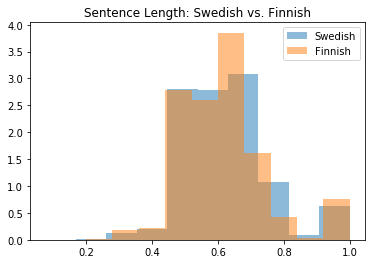

Swedish stats: DescribeResult(nobs=30000, minmax=(0.07692307692307693, 1.0), mean=0.6257828649815892, variance=0.017559055260096313, skewness=0.9676258057539265, kurtosis=1.6260642939557766)
Finnish stats: DescribeResult(nobs=30000, minmax=(0.2, 1.0), mean=0.6282786558321322, variance=0.017879751356547166, skewness=0.9421176752313591, kurtosis=1.5871406309988068)

Independence t-test:  Ks_2sampResult(statistic=0.021133333333333337, pvalue=3.034735907852759e-06)


In [34]:
showResults(depthSOld, depthSNew, "Swedish", "Finnish", "Sentence Length: Swedish vs. Finnish")